# IMPORT

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Dataset.MNIST.mnist import load_mnist
from Common.util import smooth_curve
from Common.MLN import MultiLayerNet

-----

# 매개변수 갱신의 여러 기법들

## 확률적 경사 하강법 (SGD)

- 비등방성 함수에서 탐색경로가 비효율적이다.

In [2]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr*grads[key]

----

## 모멘텀

- 운동량을 의미하며, 아무런 힘을 받지 않을 때 서서히 하강시킨다.

- SGD보다는 지그재그 정도가 덜하다.

In [3]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]

## AdaGrad

- 학습을 진행하면서 학습률을 점차 줄여나가는 방법 중 하나로, 매개변수 전체의 학습률 값을 일괄적으로 낮추는 방법을 발전시킨 것이다.
- 각각의 매개변수에 맞춤형 값을 만들어준다.
- 과거의 기울기를 제곱해 계속 더해나가며 학습을 진행할 수록 갱신 강도가 약해진다.
- 무한히 계속하면 갱신량이 0이 되어버리는데, 이를 개선한 방법으로 RMSProp이라는 방법이 존재한다.

In [4]:
class AdaGrad:

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            # 마지막에 존재하는 1e-7 값은 0으로 나누는 일을 막아준다.
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

## RMSProp

- RMSProp은 지수이동평균(EMA: Exponential Moving Average)라는 사용한다.
- EMA는 과거의 기울기를 서서히 잊고 새로운 기울기 정보를 크게 반영하는 방법을 사용해 과거 기울기 반영 규모를 감소시킨다.

In [5]:
class RMSprop:

    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

-----

## Adam

- 2015년에 제안된 방법이다.
- 모멘텀과 AdaGrad를 융합한 것 같은 방법이다.
- 편향 보정이 진행된다.
- 참고: http://arxiv.org/abs/1412.6980v8

In [6]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

-----

# 방법들의 비교

## MNIST Data 읽어오기

In [7]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

## 함수의 설정

In [8]:
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
optimizers['RMSprop'] = RMSprop()

In [9]:
networks = {}
train_loss = {}

In [10]:
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    

## 학습 시작

In [11]:
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(f"{key} : {loss:.4f}")

===========iteration:0===========
SGD : 2.3050
Momentum : 2.3798
AdaGrad : 2.2888
Adam : 2.2166
RMSprop : 13.4737
===========iteration:100===========
SGD : 1.4653
Momentum : 0.3623
AdaGrad : 0.1839
Adam : 0.2751
RMSprop : 0.3654
===========iteration:200===========
SGD : 0.7058
Momentum : 0.1697
AdaGrad : 0.1209
Adam : 0.1338
RMSprop : 0.1832
===========iteration:300===========
SGD : 0.6402
Momentum : 0.3242
AdaGrad : 0.1392
Adam : 0.2210
RMSprop : 0.2655
===========iteration:400===========
SGD : 0.3966
Momentum : 0.1725
AdaGrad : 0.0682
Adam : 0.1441
RMSprop : 0.2078
===========iteration:500===========
SGD : 0.3708
Momentum : 0.1506
AdaGrad : 0.0599
Adam : 0.1152
RMSprop : 0.2270
===========iteration:600===========
SGD : 0.3447
Momentum : 0.1321
AdaGrad : 0.0464
Adam : 0.0740
RMSprop : 0.0725
===========iteration:700===========
SGD : 0.3464
Momentum : 0.1145
AdaGrad : 0.0459
Adam : 0.0667
RMSprop : 0.2054
===========iteration:800===========
SGD : 0.3956
Momentum : 0.1844
AdaGrad : 0.13

## 그래프 표시

In [12]:
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D", "RMSprop": "h"}

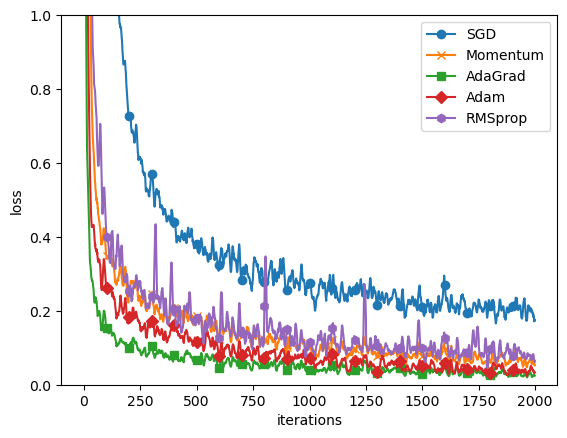

In [13]:
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()